In [53]:
import sys
import numpy as np
sys.path.insert(0, '/global/u1/k/kovacs/gcr-catalogs_agn/') 
import GCRCatalogs
%matplotlib inline
from matplotlib import pyplot as plt

In [54]:
agn = GCRCatalogs.load_catalog('AGN_mean_mags_v1.1.4')

In [110]:
all_bands = ['mag_{}_no_agn_extinction_lsst'.format(b) for b in ['g', 'r', 'i', 'z']]
agn_bands = ['mag_{}_agnonly_no_agn_extinction_lsst'.format(b) for b in ['g', 'r', 'i', 'z']]
other = ['redshift', 'Mag_true_i_agnonly_no_agn_extinction_lsst_z0']
agn_q = all_bands + agn_bands + other
agn_data = agn.get_quantities(agn_q)
print(agn_data.keys())

dict_keys(['redshift', 'mag_g_agnonly_no_agn_extinction_lsst', 'mag_r_agnonly_no_agn_extinction_lsst', 'mag_i_no_agn_extinction_lsst', 'Mag_true_i_agnonly_no_agn_extinction_lsst_z0', 'mag_z_no_agn_extinction_lsst', 'mag_g_no_agn_extinction_lsst', 'mag_i_agnonly_no_agn_extinction_lsst', 'mag_z_agnonly_no_agn_extinction_lsst', 'mag_r_no_agn_extinction_lsst'])


In [111]:
zedges = [0.3, 0.68, 1.06, 1.44, 1.82, 2.20, 2.6, 3.0]
def get_zmasks(zedges, redshift, Mmask):
    zmasks = {}
    zlo = zedges[:-1]
    zhi = zedges[1:]
    for zl, zh in zip(zlo, zhi):
        zmasks['{}<z<{}'.format(zl, zh)] = (redshift > zl) & (redshift < zh)
        
    zmasks['0.3 < z < 2.2'] = (redshift > 0.3) & (redshift < 2.2)
    for k, v in zmasks.items():
        print('#AGN({}): {}; ({:.3f}), #AGN(M&z): {}; ({:.3f})'.format(k, np.count_nonzero(v), np.count_nonzero(v)/float(len(v)),
              np.count_nonzero(v & Mmask), np.count_nonzero(v & Mmask)/float(len(v))))
        
    return zmasks

In [114]:
M_min=-22.5
Mag_key = 'Mag_true_i_agnonly_no_agn_extinction_lsst_z0'
Mmask = (agn_data[Mag_key] < M_min)
print('#AGN(M<-22.5): {}; ({:.3f})'.format(np.count_nonzero(Mmask), np.count_nonzero(Mmask)/float(len(Mmask))))
zmasks = get_zmasks(zedges, agn_data['redshift'], Mmask)
print(np.min(agn_data[Mag_key]), np.max(agn_data[Mag_key]))

#AGN(M<-22.5): 628675; (0.020)
#AGN(0.3<z<0.68): 2774043; (0.089), #AGN(M&z): 2366; (0.000)
#AGN(0.68<z<1.06): 4871414; (0.157), #AGN(M&z): 16120; (0.001)
#AGN(1.06<z<1.44): 5789864; (0.187), #AGN(M&z): 49790; (0.002)
#AGN(1.44<z<1.82): 5307304; (0.171), #AGN(M&z): 93636; (0.003)
#AGN(1.82<z<2.2): 4649234; (0.150), #AGN(M&z): 127418; (0.004)
#AGN(2.2<z<2.6): 4015657; (0.129), #AGN(M&z): 159143; (0.005)
#AGN(2.6<z<3.0): 3012424; (0.097), #AGN(M&z): 165918; (0.005)
#AGN(0.3 < z < 2.2): 23391859; (0.754), #AGN(M&z): 289330; (0.009)
-31.164916760409536 -12.042476399650187


In [115]:
bands = ['g', 'i']
for b in bands:
    agn_data['fraction_{}'.format(b)] = np.power(10.,
                                        -0.4*(agn_data['mag_{}_agnonly_no_agn_extinction_lsst'.format(b)] - \
                                              agn_data['mag_{}_no_agn_extinction_lsst'.format(b)]))
                                        
    print(b, np.min(agn_data['fraction_{}'.format(b)]), np.max(agn_data['fraction_{}'.format(b)]))

g 0.00029507876898485403 0.9999509887815128
i 0.00018110848966746874 0.9996987968943823


In [124]:
from matplotlib.colors import LogNorm
import matplotlib.colors as colors
def plot_fractions(fractions, Mag, zmasks, band='g', Mlo=-28., Mhi=-14.,
                   Nxbins=40, Nybins=50, agn_map='viridis', Mi_cut=-22.5, frac_cut=0.5):
    fig, ax_all = plt.subplots(2, 4, figsize=(15, 8), sharex='col')
    for n, (ax, (zk, maskz)) in enumerate(zip(ax_all.flat, zmasks.items())):
        
        agn, xedges, yedges = np.histogram2d(Mag[maskz], fractions[maskz],
                                             bins=(Nxbins, Nybins))
        #print(xedges, yedges)
        x_cen, y_cen = np.meshgrid(xedges[:-1], yedges[:-1])
        x_cen += (0.5*(xedges[1]-xedges[0]))  #find bin centers
        y_cen += (0.5*(yedges[1]-yedges[0]))
        x_wid = xedges[1] - xedges[0]
        y_wid = yedges[1] - yedges[0]
        
        agnmasked = np.ma.masked_where(agn.T==0.0, agn.T)
        hd2 = ax.pcolor(xedges, yedges, agnmasked, cmap=agn_map,
                        norm=colors.LogNorm(vmin=agnmasked.min(), vmax=agnmasked.max()))#, alpha=alpha2d)
        
        #h2d = ax.hist2d(Mag[maskz], fractions[maskz], bins=(Nxbins, Nybins), norm=LogNorm())
        cb2 = plt.colorbar(hd2, ax=ax)
        ax.plot([Mi_cut, Mi_cut], [0., 1.], '--m')
        ax.plot([Mlo, Mhi], [0.5, 0.5], '--m')
        rlabeld2 = '$\\rm N_{{AGN}}({})$'.format(zk)
        cb2.set_label(rlabeld2)
        ax.set_ylabel('Fraction')
        ax.set_xlim(Mlo, Mhi)
        ax.text(0.05, 0.95, '{}'.format(zk), alpha=0.9,
                transform=ax.transAxes, color='orangered', fontsize=14)
        if n > 4:
            ax.set_xlabel('$M_i$')
        
    fig.suptitle('{}'.format('AGN Flux Fraction {}-band'.format(band)), size=16)
    fig.tight_layout()
    fig.subplots_adjust(hspace=0.005)
    fig.subplots_adjust(top=0.94)
            
    figname = 'agn_fraction_{}_log.png'.format(band)
    print('Saving {}'.format(figname))
    fig.savefig(figname, bbox_inches='tight') 
        

Saving agn_fraction_g_log.png
Saving agn_fraction_i_log.png


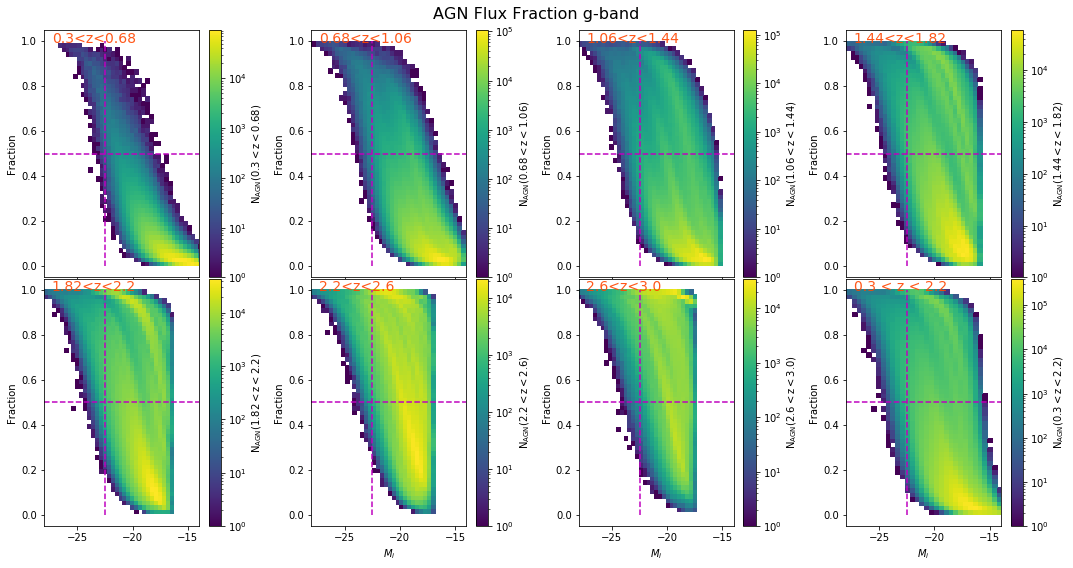

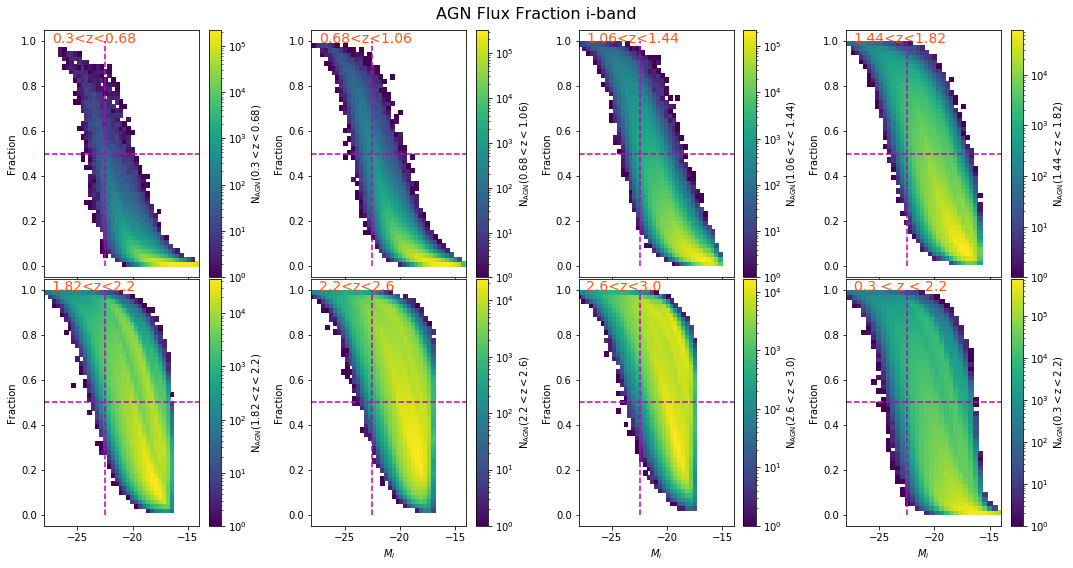

In [125]:
for band in bands:
    plot_fractions(agn_data['fraction_{}'.format(band)], 
                   agn_data[Mag_key], zmasks, band=band)

In [129]:
#check numbers
frac_cut=0.5
for b in bands:
    fmask = (agn_data['fraction_{}'.format(b)] > frac_cut) 
    print('{}: #AGN(f>{}) = {}; ({:.3f})'.format(b, frac_cut, np.count_nonzero(fmask),
                                                  np.count_nonzero(fmask)/float(len(fmask))))
    for k, v in zmasks.items():
        mask = fmask & v & Mmask
        print('{}: #AGN({}, f>{}, M_i<{}) = {}; ({:.3f})'.format(b, k, frac_cut, M_min, np.count_nonzero(mask),
                                                    np.count_nonzero(mask)/float(len(mask))))

g: #AGN(f>0.5) = 8154606; (0.263)
g: #AGN(0.3<z<0.68, f>0.5, M_i<-22.5) = 2303; (0.000)
g: #AGN(0.68<z<1.06, f>0.5, M_i<-22.5) = 15031; (0.000)
g: #AGN(1.06<z<1.44, f>0.5, M_i<-22.5) = 39530; (0.001)
g: #AGN(1.44<z<1.82, f>0.5, M_i<-22.5) = 84066; (0.003)
g: #AGN(1.82<z<2.2, f>0.5, M_i<-22.5) = 122545; (0.004)
g: #AGN(2.2<z<2.6, f>0.5, M_i<-22.5) = 158127; (0.005)
g: #AGN(2.6<z<3.0, f>0.5, M_i<-22.5) = 165141; (0.005)
g: #AGN(0.3 < z < 2.2, f>0.5, M_i<-22.5) = 263475; (0.008)
i: #AGN(f>0.5) = 6139716; (0.198)
i: #AGN(0.3<z<0.68, f>0.5, M_i<-22.5) = 1410; (0.000)
i: #AGN(0.68<z<1.06, f>0.5, M_i<-22.5) = 11264; (0.000)
i: #AGN(1.06<z<1.44, f>0.5, M_i<-22.5) = 43716; (0.001)
i: #AGN(1.44<z<1.82, f>0.5, M_i<-22.5) = 90820; (0.003)
i: #AGN(1.82<z<2.2, f>0.5, M_i<-22.5) = 126499; (0.004)
i: #AGN(2.2<z<2.6, f>0.5, M_i<-22.5) = 158613; (0.005)
i: #AGN(2.6<z<3.0, f>0.5, M_i<-22.5) = 165586; (0.005)
i: #AGN(0.3 < z < 2.2, f>0.5, M_i<-22.5) = 273709; (0.009)


In [127]:
#test filters
z_lim = [0.3, 2.2]
z_filters = ['redshift > {}'.format(z_lim[0]), 'redshift < {}'.format(z_lim[1])]
Mag_filters = ['{} < {}'.format(Mag_key, M_min)]
mag_field_key = 'mag_g_agnonly_no_agn_extinction_lsst'
test = agn.get_quantities([mag_field_key], filters=z_filters+ Mag_filters)
print(len(test[mag_field_key]))

289330
